In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = np.load('distribution.npy')

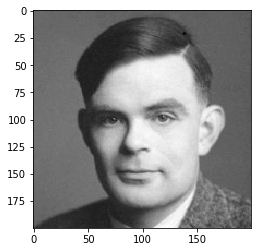

In [3]:
plt.imshow(x, cmap='gray')

In [4]:
x_flat = x.flatten()
nrof_samples = 100000
xsamp = np.random.choice(x_flat.shape[0], size=(nrof_samples,), p=x_flat)
xu = np.unravel_index(xsamp, shape=x.shape)
X = np.stack(xu).T

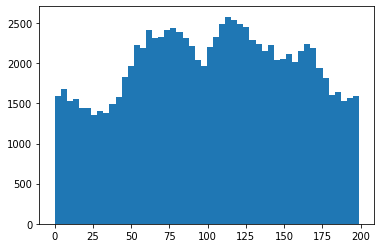

In [5]:
_ = plt.hist(X[:,0], bins=50)

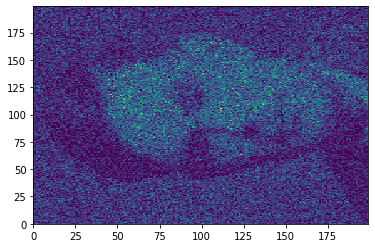

In [6]:
_ = plt.hist2d(X[:,0], X[:,1], bins=200, range=np.array([[0,199], [0,199]]))

In [7]:
nrof_test_samples = int(nrof_samples*0.2)
X_train = X[:-nrof_test_samples,:]
X_test = X[-nrof_test_samples:,:]
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (80000, 2)
X_test:  (20000, 2)


In [8]:
def log2(x):
    return tf.log(x) / tf.log(2.0)

def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Dense(units=nrof_units, kernel_initializer=tf.initializers.glorot_normal)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    x = dense(x, nrof_units=nrof_units, activation=None, training=training)
    return x

def create_model(x, nrof_dims=200):
    dbg = dict()
    x1 = x[:,0]
    theta1 = tf.get_variable(name='theta1', shape=(nrof_dims,), dtype=tf.float32, initializer=tf.zeros_initializer, trainable=True)
    th1 = tf.gather(theta1, x1)
    px1 = tf.math.exp(th1) / tf.reduce_sum(tf.math.exp(theta1)) #p(x1)
    dbg['px1'] = px1
    dbg['x1'] = x1
    dbg['th1'] = th1
    dbg['theta1'] = theta1
    dbg['theta1_norm'] = tf.math.exp(theta1) / tf.reduce_sum(tf.math.exp(theta1))
    
    x2 = x[:,1]
    dbg['x2'] = x2
    d2 = mlp(tf.one_hot(x1, nrof_dims), nrof_units=nrof_dims, activation=tf.nn.relu, nrof_layers=2)
    dbg['d2'] = d2
    
    th2 = tf.gather(d2, tf.expand_dims(x2, axis=1), batch_dims=1)
    dbg['th2'] = th2
    px2_x1 = (tf.math.exp(th2) / tf.reduce_sum(tf.math.exp(d2)))[:,0]  # p(x2|x1)
    dbg['px2'] = px2_x1
    dbg['theta2_norm'] = tf.math.exp(d2) / tf.reduce_sum(tf.math.exp(d2))  # p(x2|x1)
    px = px1 * px2_x1
    dbg['px'] = px
    loss = -tf.reduce_mean(log2(px1)+log2(px2_x1))
    dbg['log_px1'] = tf.reduce_mean(log2(px1))
    dbg['log_px2'] = tf.reduce_mean(log2(px2_x1))
    dbg['log_px'] = tf.reduce_mean(log2(px1)+log2(px2_x1))
    return loss, dbg


In [11]:
tf.reset_default_graph()
with tf.Graph().as_default():

    batch_size = 100
    x_ph = tf.placeholder(tf.int32, shape=(None,2))
    loss, dbg = create_model(x_ph, nrof_dims=200)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(loss)

    sess = tf.Session()
    sess.run(tf.compat.v1.global_variables_initializer())

    nrof_train_batches = int(np.floor(X_train.shape[0] / batch_size))
    nrof_epochs = 50
    train_loss_list = []
    dbg_list = []
    for epoch in range(1, nrof_epochs+1):
        for i in range(nrof_train_batches):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            _, loss_, dbg_ = sess.run([train_op, loss, dbg], feed_dict={x_ph: x_batch})
            train_loss_list += [ loss_ ]
            if i==0:
                dbg_list += [ dbg_ ]

        print('train epoch: %d  loss: %.3f' % (epoch, loss_/2))
    test_loss_ = sess.run(loss, feed_dict={x_ph: X_test})
    print('Test NLL: %.3f bits/dim' % (test_loss_/2))


train epoch: 1  loss: 10.937
train epoch: 2  loss: 10.924
train epoch: 3  loss: 10.920
train epoch: 4  loss: 10.917
train epoch: 5  loss: 10.914
train epoch: 6  loss: 10.912
train epoch: 7  loss: 10.908
train epoch: 8  loss: 10.905
train epoch: 9  loss: 10.901
train epoch: 10  loss: 10.896
train epoch: 11  loss: 10.892
train epoch: 12  loss: 10.887
train epoch: 13  loss: 10.882
train epoch: 14  loss: 10.878
train epoch: 15  loss: 10.873
train epoch: 16  loss: 10.869
train epoch: 17  loss: 10.865
train epoch: 18  loss: 10.862
train epoch: 19  loss: 10.859
train epoch: 20  loss: 10.856
train epoch: 21  loss: 10.853
train epoch: 22  loss: 10.851
train epoch: 23  loss: 10.848
train epoch: 24  loss: 10.846
train epoch: 25  loss: 10.844
train epoch: 26  loss: 10.842
train epoch: 27  loss: 10.841
train epoch: 28  loss: 10.839
train epoch: 29  loss: 10.837
train epoch: 30  loss: 10.836
train epoch: 31  loss: 10.834
train epoch: 32  loss: 10.833
train epoch: 33  loss: 10.832
train epoch: 34  lo

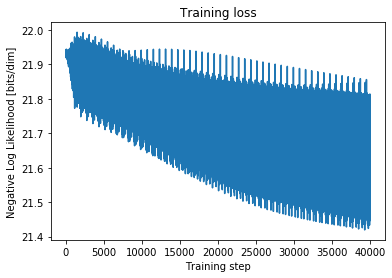

In [12]:
plt.plot(train_loss_list)
plt.title('Training loss')
plt.xlabel('Training step')
_ = plt.ylabel('Negative Log Likelihood [bits/dim]')

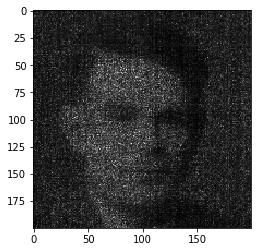

In [13]:
x1, x2 = np.meshgrid(np.arange(200), np.arange(200))
X_mesh = np.vstack([x1.flatten(),x2.flatten()]).T
px = np.zeros(shape=(200,200), dtype=np.float32)
nrof_batches = X_mesh.shape[0] // 200
dbg_ = sess.run(dbg, feed_dict={x_ph: X_mesh})
px = dbg_['px']
_ = plt.imshow(np.rot90(np.reshape(px, (200,200)), k=3), cmap='gray')